In [1]:
# Data is from https://empowerprogram.hhs.gov/about-empowermap.html

In [2]:
import pandas as pd

In [3]:
# Import excel files of empower DME users

years = [2016, 2017, 2018, 2019, 2020, 2021]

dataframes = [pd.ExcelFile(str(year)+"_HHSemPOWERMapHistoricalDataset.xlsx").parse("Zip Code") for year in years]

In [4]:
# import nyc zip codes and population

nyc_zip = pd.read_csv('/Users/minjukim/Documents/codes/Reporting2/df_nyc_zip.csv')

In [5]:
nyc_dfs = [dataframe.merge(nyc_zip, how="right", left_on='Zip_Code', right_on = 'Zipcode') for dataframe in dataframes]


In [6]:
for i, df in enumerate(nyc_dfs):
    nyc_dfs[i] = df.drop(["Zipcode", "Unnamed: 0"], axis=1)
    for month in range(1, 13):
        nyc_dfs[i][month] = df[df.columns[month*2+5]]/df[df.columns[month*2+4]]*100

In [7]:
years=[]
for i, df in enumerate(nyc_dfs):
    dme_pop = {}
    for month in range(1, 13):
        dme_pop[month] = nyc_dfs[i][month].mean()
    years.append(dme_pop)

In [8]:
monthly_df = pd.DataFrame(years).transpose()
monthly_df.columns = monthly_df.columns+2016
monthly_df.reset_index(inplace=True, names="month")

In [9]:
monthly_df.month = monthly_df.month.astype(str).str.zfill(2)

In [10]:
melted_monthly = pd.melt(monthly_df, id_vars='month', var_name="year", value_name='pct_DME_users')

In [11]:
melted_monthly['date'] = melted_monthly.year.astype(str) + "-" + melted_monthly.month.astype(str)

In [12]:
melted_monthly.date = pd.to_datetime(melted_monthly.date, format="%Y-%m")

In [13]:
# Get zip code data on most recent data available.
df_2022 = pd.ExcelFile("2022_HHSemPOWERMapHistoricalDataset.xlsx").parse("Zip Code")

In [14]:
df_2022['August'] = df_2022['Aug_2022_Power_Dependent_Devices_DME']/df_2022["Aug_2022_Medicare_Benes"]*100

In [15]:
df_2022 = df_2022.merge(nyc_zip, how="inner", left_on='Zip_Code', right_on = 'Zipcode')

In [16]:
df_2022 = df_2022[df_2022.County!="Nassau "]

## Comparing oldest and newest datapoint.

In [17]:
nyc_dfs[0]["Jan_2016_Medicare_Benes"].sum()

1094567.0

In [18]:
nyc_dfs[0]["Jan_2016_Power_Dependent_Devices_DME"].sum()

25226.0

In [19]:
df_2022["Aug_2022_Medicare_Benes"].sum()


1338990

In [20]:
df_2022["Aug_2022_Power_Dependent_Devices_DME"].sum()

35703

In [21]:
df_2022.August.mean()

3.7922225819773474

In [35]:
df_2022

,Zip_Code,FIPS_Code,County_FIPS_Code,County,State_FIPS_Code,State,Jan_2022_Medicare_Benes,Jan_2022_Power_Dependent_Devices_DME,Feb_2022_Medicare_Benes,Feb_2022_Power_Dependent_Devices_DME,...,Jul_2022_Power_Dependent_Devices_DME,Aug_2022_Medicare_Benes,Aug_2022_Power_Dependent_Devices_DME,August,Unnamed: 0,Zipcode,Estimate,Margin of Error,Lower Estimate,Upper Estimate
0,10001,36061,61,New York,36,NY,4736,114,4720,107,...,117,4677,119,2.544366,0,10001,25026,1759,23267,26785
1,10002,36061,61,New York,36,NY,18738,460,18731,445,...,472,18867,488,2.586527,1,10002,74363,3183,71180,77546
2,10003,36061,61,New York,36,NY,8932,237,8913,235,...,243,8878,239,2.692048,2,10003,54671,2568,52103,57239
3,10004,36061,61,New York,36,NY,811,16,807,17,...,19,810,17,2.098765,3,10004,3310,658,2652,3968
4,10005,36061,61,New York,36,NY,325,11,328,11,...,11,339,11,3.244838,4,10005,8664,906,7758,9570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,11691,36081,81,Queens,36,NY,9788,323,9741,324,...,334,9899,331,3.343772,209,11691,68454,3192,65262,71646
187,11692,36081,81,Queens,36,NY,2971,69,2972,68,...,92,3006,98,3.260146,210,11692,22394,1856,20538,24250
188,11693,36081,81,Queens,36,NY,2427,71,2430,70,...,71,2453,71,2.894415,211,11693,13029,1251,11778,14280
189,11694,36081,81,Queens,36,NY,4478,102,4468,105,...,103,4519,109,2.412038,212,11694,21258,1683,19575,22941


## Cross referencing DME dependency with household income

In [22]:
income_df = pd.read_csv("acs2020_5yr_B19013_86000US10460/acs2020_5yr_B19013_86000US10460.csv")

In [23]:
# Rename and simplify columns

income_df = income_df.rename({"name": "Zip_Code", "B19013001": "median_household_income"}, axis="columns")

In [24]:
dme_income_df = pd.merge(df_2022, income_df)

In [25]:
# Exclude zip codes where poluation is 0 or close to 0

dme_income_df = dme_income_df[(dme_income_df.Estimate!=0) & (dme_income_df.median_household_income.notnull())]

In [26]:
# dme_income_df.to_csv('dme_income.csv')

Text(0, 0.5, 'Pct of electric medical equipment users')

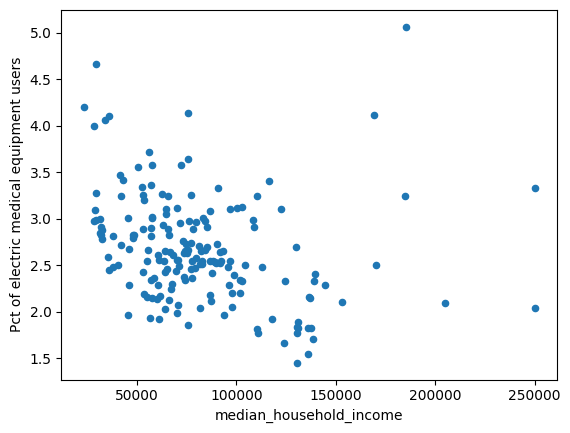

In [27]:
ax = dme_income_df.plot(x="median_household_income", y="August", kind="scatter")
ax.set_ylabel("Pct of electric medical equipment users")

In [28]:
dme_income_df.plot

In [29]:
dme_income_df

,Zip_Code,FIPS_Code,County_FIPS_Code,County,State_FIPS_Code,State,Jan_2022_Medicare_Benes,Jan_2022_Power_Dependent_Devices_DME,Feb_2022_Medicare_Benes,Feb_2022_Power_Dependent_Devices_DME,...,August,Unnamed: 0,Zipcode,Estimate,Margin of Error,Lower Estimate,Upper Estimate,geoid,median_household_income,"B19013001, Error"
0,10001,36061,61,New York,36,NY,4736,114,4720,107,...,2.544366,0,10001,25026,1759,23267,26785,86000US10001,96787.0,9861.0
1,10002,36061,61,New York,36,NY,18738,460,18731,445,...,2.586527,1,10002,74363,3183,71180,77546,86000US10002,35607.0,2214.0
2,10003,36061,61,New York,36,NY,8932,237,8913,235,...,2.692048,2,10003,54671,2568,52103,57239,86000US10003,129981.0,8865.0
3,10004,36061,61,New York,36,NY,811,16,807,17,...,2.098765,3,10004,3310,658,2652,3968,86000US10004,204949.0,12375.0
4,10005,36061,61,New York,36,NY,325,11,328,11,...,3.244838,4,10005,8664,906,7758,9570,86000US10005,184681.0,14575.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,11691,36081,81,Queens,36,NY,9788,323,9741,324,...,3.343772,209,11691,68454,3192,65262,71646,86000US11691,52605.0,3067.0
184,11692,36081,81,Queens,36,NY,2971,69,2972,68,...,3.260146,210,11692,22394,1856,20538,24250,86000US11692,53077.0,7883.0
185,11693,36081,81,Queens,36,NY,2427,71,2430,70,...,2.894415,211,11693,13029,1251,11778,14280,86000US11693,52946.0,12260.0
186,11694,36081,81,Queens,36,NY,4478,102,4468,105,...,2.412038,212,11694,21258,1683,19575,22941,86000US11694,87755.0,7930.0


In [30]:
income_df.geoid = income_df.geoid[-5:]

## Cross referencing DME dependency with pct below poverty

In [31]:
pct_below_poverty = pd.read_csv("housing_data.csv")

In [34]:
pct_below_poverty = pct_below_poverty[['zip', 'pct_below_poverty']]

In [51]:
poverty_dme = df_2022.merge(pct_below_poverty, left_on="Zip_Code", right_on="zip")
poverty_dme = poverty_dme[['Zip_Code', 'August', 'pct_below_poverty']]
poverty_dme

,Zip_Code,August,pct_below_poverty
0,10001,2.544366,13.06
1,10002,2.586527,27.36
2,10003,2.692048,9.20
3,10004,2.098765,1.32
4,10005,3.244838,9.46
...,...,...,...
178,11436,2.756211,11.24
179,11691,3.343772,19.42
180,11692,3.260146,25.60
181,11693,2.894415,14.34


In [59]:
# Drop Airport

poverty_dme.drop(173, inplace=True)

In [61]:
poverty_dme.to_csv("poverty_dme.csv")

Text(0, 0.5, 'Pct of electric medical equipment users')

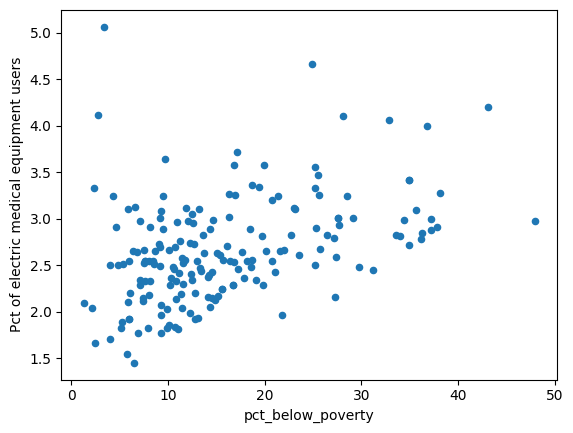

In [60]:
ax = poverty_dme.plot(x="pct_below_poverty", y="August", kind="scatter")
ax.set_ylabel("Pct of electric medical equipment users")

# Factor in age to the existing plot

In [49]:
import json

age_df = pd.read_csv("acs2020_5yr_B01001_86000US10460/acs2020_5yr_B01001_86000US10460.csv")

with open("acs2020_5yr_B01001_86000US10460/metadata.json") as f:
    metadata = json.load(f)

In [52]:
name_of_cols = {k:v["name"] for k, v in metadata["tables"]["B01001"]["columns"].items()}

In [53]:
age_df.rename(columns=name_of_cols, inplace=True)

In [55]:
melted_age = age_df.melt(id_vars=['geoid', 'name'])

In [58]:
pd.options.display.max_columns=None

pivoted_age = melted_age.pivot_table(index=["name", "geoid"], columns="variable", values="value", aggfunc="sum").reset_index()


In [60]:
# Remove margin of error columns
pivoted_age.drop(list(pivoted_age.filter(regex = 'Error')), axis = 1, inplace = True)

In [62]:
pct_dict = {}

for col in pivoted_age.columns[4:-4]:
    pct_dict[col] = pivoted_age[col] / pivoted_age["Total:"]*100

In [63]:
pct_df = pd.DataFrame(pct_dict)

In [64]:
pct_df = pd.concat([pct_df, pd.DataFrame(pivoted_age.name)], axis=1)

In [65]:
pct_df.rename(columns={"name":"zip"}, inplace=True)

In [67]:
pct_df.columns

Index(['18 and 19 years', '20 years', '21 years', '22 to 24 years',
       '25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years',
       '45 to 49 years', '5 to 9 years', '50 to 54 years', '55 to 59 years',
       '60 and 61 years', '62 to 64 years', '65 and 66 years',
       '67 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years',
       '85 years and over', 'zip'],
      dtype='object')

In [78]:
pct_df["percent_elderly"] = pct_df[['65 and 66 years','67 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years','85 years and over']].sum(axis=1)
merged_income_age = pct_df[["zip", "percent_elderly"]].merge(dme_income_df, left_on="zip", right_on="Zip_Code")
merged_income_age[["August", "median_household_income", "zip", "percent_elderly"]].to_csv("merged_income_age.csv")
